In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as stats
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,GradientBoostingClassifier,GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OneHotEncoder,LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier #importing liabraries

In [35]:
df = pd.read_csv("farm_milk_production.csv")
df.head() #loading dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              600 non-null    object 
 1   Cow_ID            600 non-null    object 
 2   Feed_kg           600 non-null    float64
 3   Temp_C            600 non-null    float64
 4   Humidity          600 non-null    int64  
 5   Milking_Time_min  600 non-null    int64  
 6   Milk_Liters       600 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 32.9+ KB


In [36]:
print(df.info())
print(df.describe().T) #checking the data types and summary statistics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              600 non-null    object 
 1   Cow_ID            600 non-null    object 
 2   Feed_kg           600 non-null    float64
 3   Temp_C            600 non-null    float64
 4   Humidity          600 non-null    int64  
 5   Milking_Time_min  600 non-null    int64  
 6   Milk_Liters       600 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 32.9+ KB
None
                  count       mean       std    min      25%     50%     75%  \
Feed_kg           600.0  11.934967  1.538374   6.08  10.8975  12.085  12.940   
Temp_C            600.0  25.071833  2.149649  18.10  23.6750  25.150  26.500   
Humidity          600.0  60.143333  6.141850  50.00  55.0000  60.000  65.000   
Milking_Time_min  600.0  14.903333  3.186573  10.00  12.0000  15.000  18.000   
Milk_

In [37]:
df.duplicated().sum()  #checking for duplicates

np.int64(0)

<Axes: >

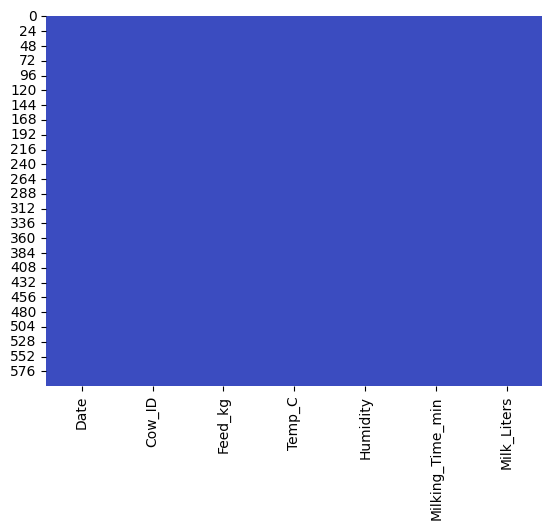

In [38]:
sns.heatmap(df.isnull(), cbar=False, cmap="coolwarm") #visualizing missing values using heatmap

<Axes: >

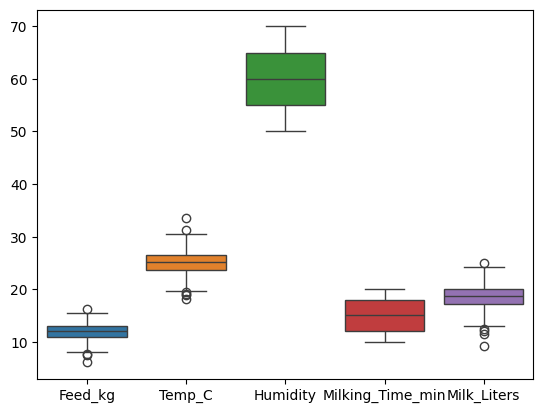

In [39]:
sns.boxplot(df) #visualizing outliers using boxplot

In [40]:
df.head()

,Date,Cow_ID,Feed_kg,Temp_C,Humidity,Milking_Time_min,Milk_Liters
0,2025-06-01,C001,9.61,25.1,59,17,17.70
1,2025-06-01,C002,11.46,22.9,63,14,17.81
2,2025-06-01,C003,12.03,23.2,65,10,16.73
3,2025-06-01,C004,11.98,27.5,67,20,19.04
4,2025-06-01,C005,13.95,24.6,55,10,18.17


<Axes: xlabel='Milk_Liters', ylabel='Count'>

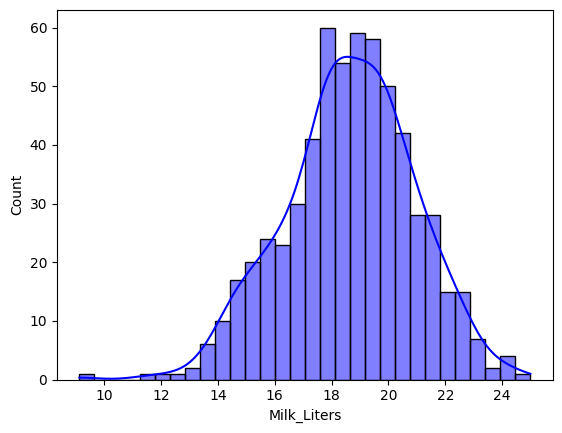

In [41]:
sns.histplot(df["Milk_Liters"], kde=True, bins=30,color='b',cbar=False, ) 
#Single Variate Analysis of Milk per Liters
#visualizing the distribution of target variable 'Milk_Liters' using histogram
# The distribution appears to be right-skewed with a peak around 5000 liters.


In [42]:
#Apply Shapiro vilk test to check the normal Distribution
stat , p = stats.shapiro(df["Milk_Liters"])
print(f"Shapiro-Wilk Test: Statistic={stat}\np-value={p}")
if p > 0.05:
    print("The data is normally distributed.")
else:
    print("The data is not normally distributed.")

Shapiro-Wilk Test: Statistic=0.994657282009908
p-value=0.034407432832096865
The data is not normally distributed.


<Axes: xlabel='Feed_kg', ylabel='Count'>

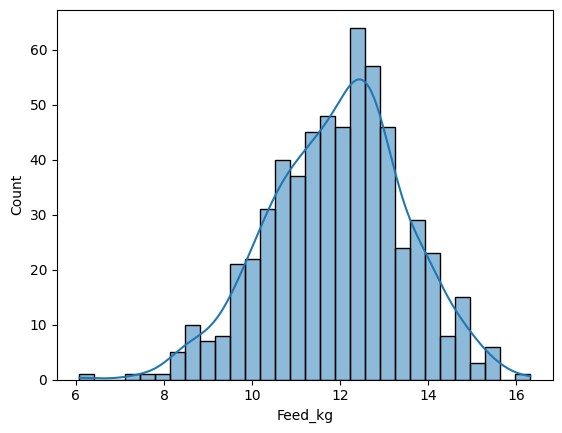

In [43]:
# Visualizing the distribution of 'Feed_kg' using histogram
sns.histplot(df["Feed_kg"], kde=True, bins=30)

In [44]:
stat , p = stats.shapiro(df["Feed_kg"])
print(f"Shapiro-Wilk Test: Statistic={stat}\np-value={p}")
if p > 0.05:
    print("The data is normally distributed.")
else:
    print("The data is not normally distributed.")

Shapiro-Wilk Test: Statistic=0.995729982805322
p-value=0.10088812143518561
The data is normally distributed.


In [45]:
df.head()

,Date,Cow_ID,Feed_kg,Temp_C,Humidity,Milking_Time_min,Milk_Liters
0,2025-06-01,C001,9.61,25.1,59,17,17.70
1,2025-06-01,C002,11.46,22.9,63,14,17.81
2,2025-06-01,C003,12.03,23.2,65,10,16.73
3,2025-06-01,C004,11.98,27.5,67,20,19.04
4,2025-06-01,C005,13.95,24.6,55,10,18.17


<Axes: xlabel='Temp_C', ylabel='Milk_Liters'>

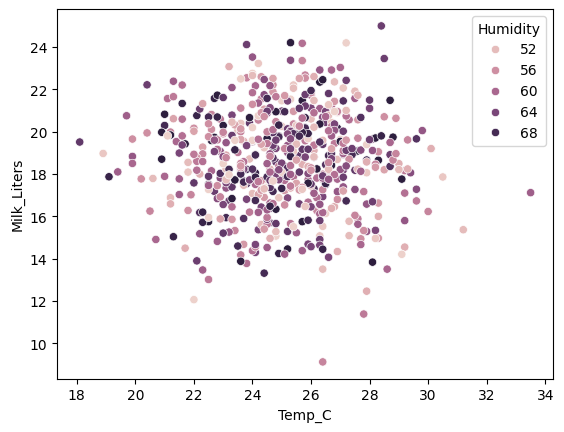

In [46]:
# bivariate Analysis
sns.scatterplot(data=df, x="Temp_C", y="Milk_Liters", hue="Humidity")

<Axes: xlabel='Feed_kg', ylabel='Milk_Liters'>

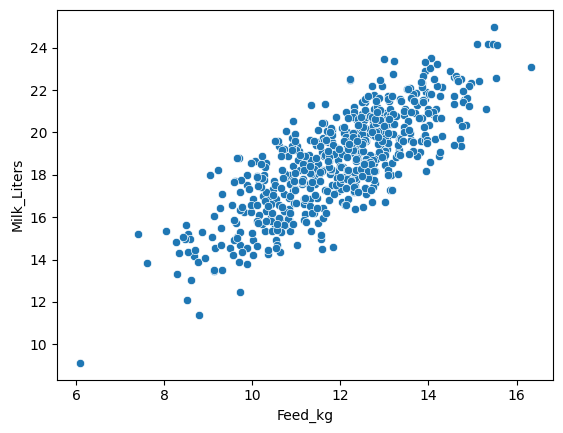

In [47]:
sns.scatterplot(data=df, x="Feed_kg", y="Milk_Liters")

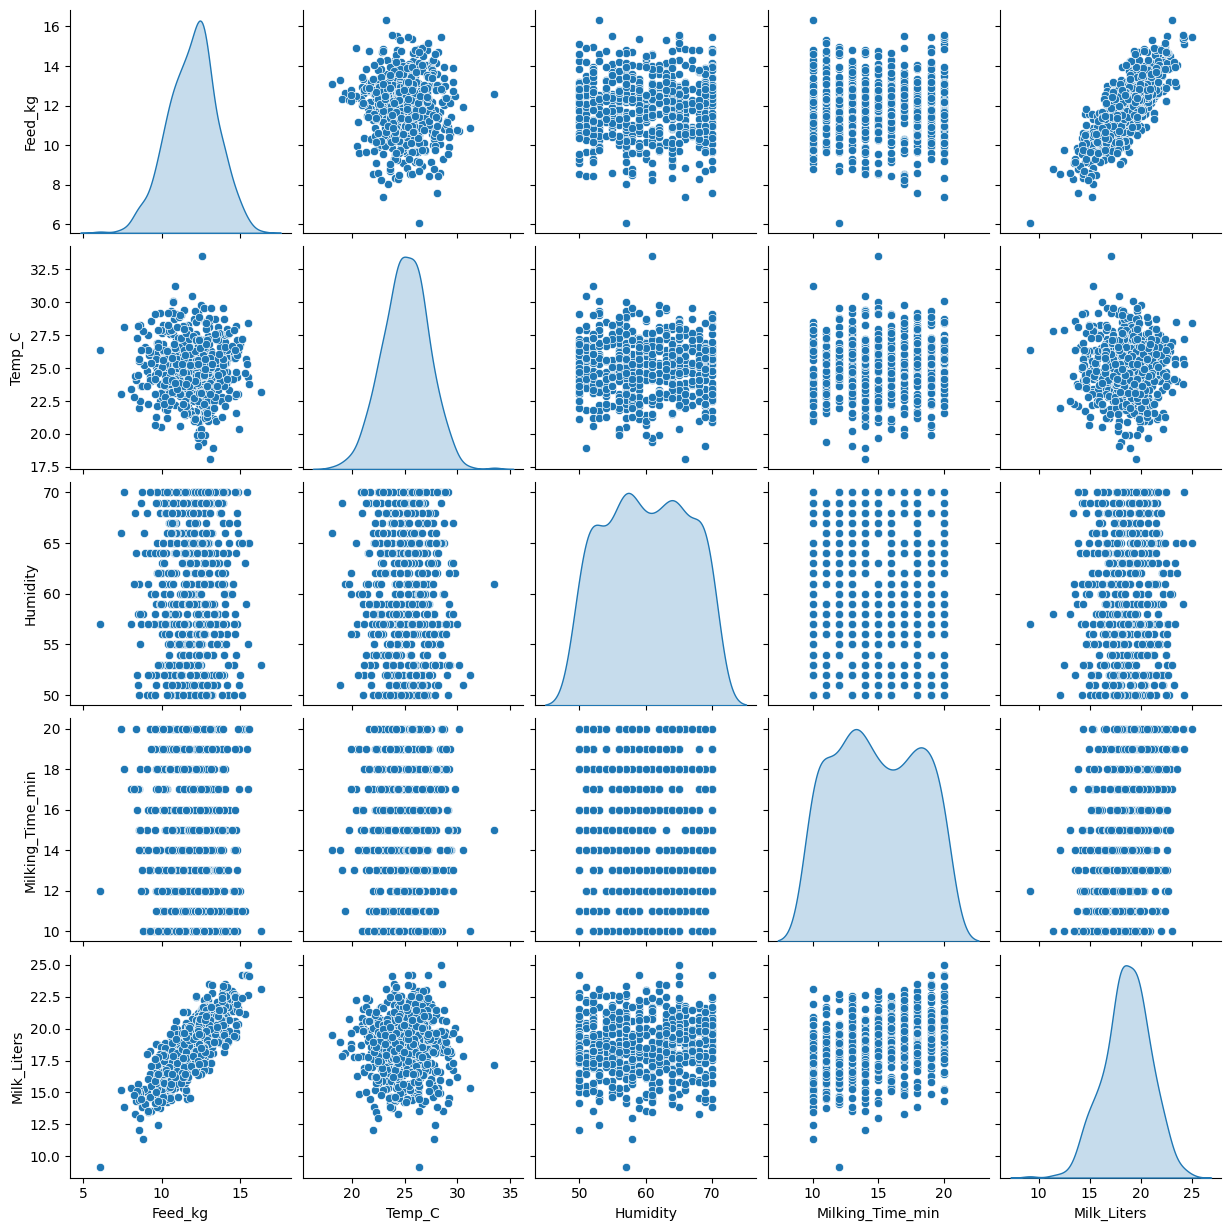

In [48]:
sns.pairplot(df, diag_kind="kde", markers="o")

<Axes: >

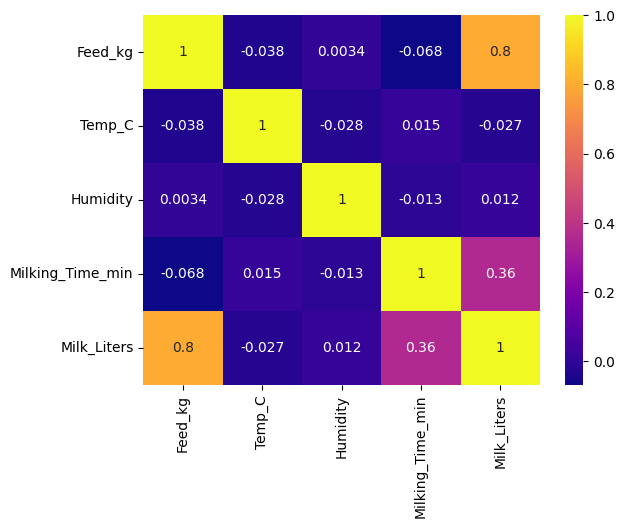

In [49]:
num_col = df.select_dtypes(include=[np.number])
sns.heatmap(num_col.corr(), annot=True, cmap="plasma")

In [50]:
# Data Preprocessing
# checking missing values
df.isnull().sum()

Date                0
Cow_ID              0
Feed_kg             0
Temp_C              0
Humidity            0
Milking_Time_min    0
Milk_Liters         0
dtype: int64

In [51]:
# Feature Engineering
# Creating a new feature 'temp_humidity_ratio'
# This feature represents the ratio of temperature to humidity, which might have an impact on milk production.

df["temp_humidity_ratio"] = df["Temp_C"] / (df["Humidity"] + 1)

In [52]:
# Dropping irrelevant columns
df_new = df.drop(columns=["Date","Cow_ID"])

In [53]:
df_new.head()

,Feed_kg,Temp_C,Humidity,Milking_Time_min,Milk_Liters,temp_humidity_ratio
0,9.61,25.1,59,17,17.70,0.418333
1,11.46,22.9,63,14,17.81,0.357812
2,12.03,23.2,65,10,16.73,0.351515
3,11.98,27.5,67,20,19.04,0.404412
4,13.95,24.6,55,10,18.17,0.439286


In [54]:
# Outlier clipping for numeric columns
num_cols = df_new.select_dtypes(include=[np.number]).columns
for col in num_cols:
    q1 = df_new[col].quantile(0.25)
    q3 = df_new[col].quantile(0.75)
    iqr = q3 - q1
    df_new[col] = df_new[col].clip(q1 - 1.5*iqr, q3 + 1.5*iqr)

# Log transformation for skewed target
df_new["Milk_Liters_log"] = np.log1p(df_new["Milk_Liters"])
df_new.head()


,Feed_kg,Temp_C,Humidity,Milking_Time_min,Milk_Liters,temp_humidity_ratio,Milk_Liters_log
0,9.61,25.1,59,17,17.70,0.418333,2.928524
1,11.46,22.9,63,14,17.81,0.357812,2.934389
2,12.03,23.2,65,10,16.73,0.351515,2.875258
3,11.98,27.5,67,20,19.04,0.404412,2.997730
4,13.95,24.6,55,10,18.17,0.439286,2.953347


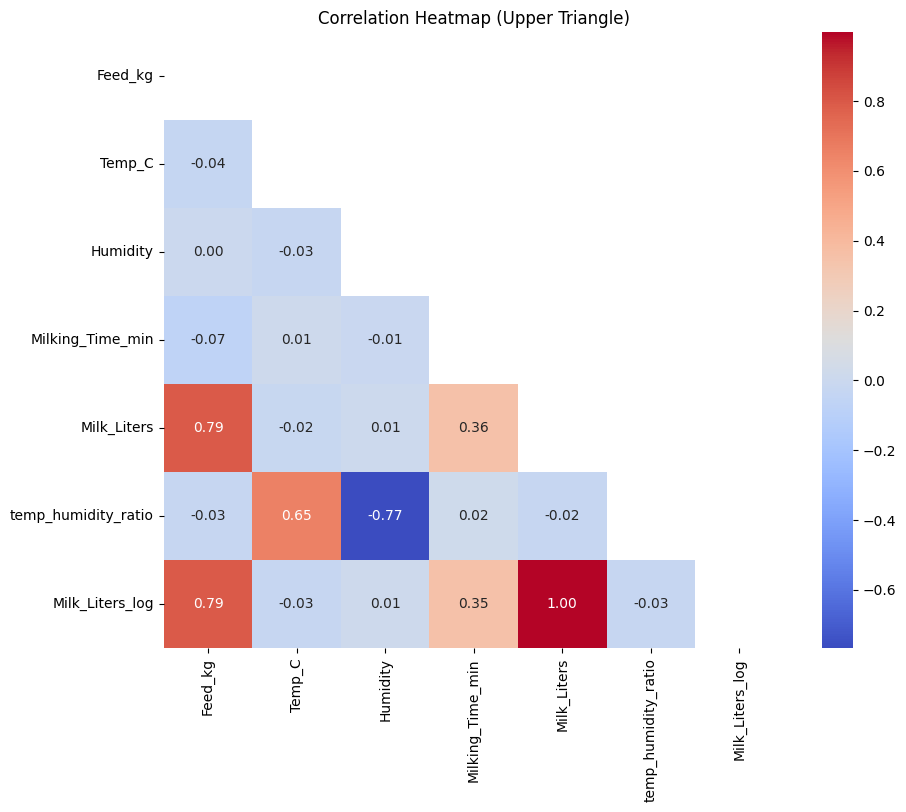

In [55]:
# Upper-triangle correlation heatmap
corr = df_new.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10,8))
sns.heatmap(corr, mask=mask, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Upper Triangle)")
plt.show()

# Interactive scatterplot using Plotly
import plotly.express as px
fig = px.scatter(df_new, x='Feed_kg', y='Milk_Liters', color='Temp_C',
                 size='Humidity', title="Milk vs Feed colored by Temperature")
fig.show()


In [56]:
# Model Building
X = df_new.drop(columns=["Milk_Liters","Humidity","Temp_C"])
y = df_new["Milk_Liters"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
num_col = X.select_dtypes(include=["float64", "int64"]).columns
cat_col = X.select_dtypes(exclude=["float64", "int64"]).columns
num_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_col),
        ("cat", cat_transformer, cat_col)
    ]
)

In [57]:
# Model Training
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
models = [
    ("Random Forest Regressor", RandomForestRegressor(random_state=42)),
    ("Decision Tree Regressor", DecisionTreeRegressor(random_state=42)),
    ("Linear Regression", LinearRegression()),
    ("SVR", SVR()),
    ("KNeighbors Regressor", KNeighborsRegressor()),
    ("XGBoost Regressor", XGBRegressor(random_state=42)),
]

results = []

for name, model in models:
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor), 
        ("model", model)
    ])
    
    # Cross-validation with R² score
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="r2")
    y_pred = cross_val_predict(pipeline, X_test, y_test, cv=5)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    results.append({
        "Model": name,
        "CV Mean R2": cv_scores.mean(),
        "CV Std": cv_scores.std(),
        "RMSE": rmse,
        "MSE": mse,
        "R2":r2
    })

    print(f"{name} | Mean R2: {cv_scores.mean():.4f} | Std: {cv_scores.std():.4f} | RMSE: {rmse:.4f} | MSE: {mse:.4f} | R2: {r2:.4f}")

# Convert results to DataFrame for visualization
cv_df = pd.DataFrame(results)

Random Forest Regressor | Mean R2: 0.9996 | Std: 0.0002 | RMSE: 0.2077 | MSE: 0.0431 | R2: 0.9919
Decision Tree Regressor | Mean R2: 0.9987 | Std: 0.0013 | RMSE: 0.3039 | MSE: 0.0924 | R2: 0.9826
Linear Regression | Mean R2: 0.9942 | Std: 0.0010 | RMSE: 0.1934 | MSE: 0.0374 | R2: 0.9930
SVR | Mean R2: 0.9811 | Std: 0.0115 | RMSE: 0.7816 | MSE: 0.6110 | R2: 0.8850
KNeighbors Regressor | Mean R2: 0.9552 | Std: 0.0081 | RMSE: 0.7856 | MSE: 0.6172 | R2: 0.8838
XGBoost Regressor | Mean R2: 0.9989 | Std: 0.0002 | RMSE: 0.2353 | MSE: 0.0554 | R2: 0.9896


In [58]:
# Model Comparison and Evaluation
print(cv_df)

                     Model  CV Mean R2    CV Std      RMSE       MSE        R2
0  Random Forest Regressor    0.999589  0.000202  0.207671  0.043127  0.991884
1  Decision Tree Regressor    0.998697  0.001323  0.303923  0.092369  0.982616
2        Linear Regression    0.994209  0.000963  0.193387  0.037398  0.992962
3                      SVR    0.981115  0.011463  0.781645  0.610970  0.885018
4     KNeighbors Regressor    0.955184  0.008119  0.785626  0.617208  0.883844
5        XGBoost Regressor    0.998885  0.000228  0.235298  0.055365  0.989581


In [59]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

estimators = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42)),
    ('knn', KNeighborsRegressor())
]

stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge()
)

stack_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", stack_model)
])

stack_pipeline.fit(X_train, y_train)
y_pred_stack = stack_pipeline.predict(X_test)

print("Stacking Regressor R2 Score:", r2_score(y_test, y_pred_stack))


Stacking Regressor R2 Score: 0.9998590265192628


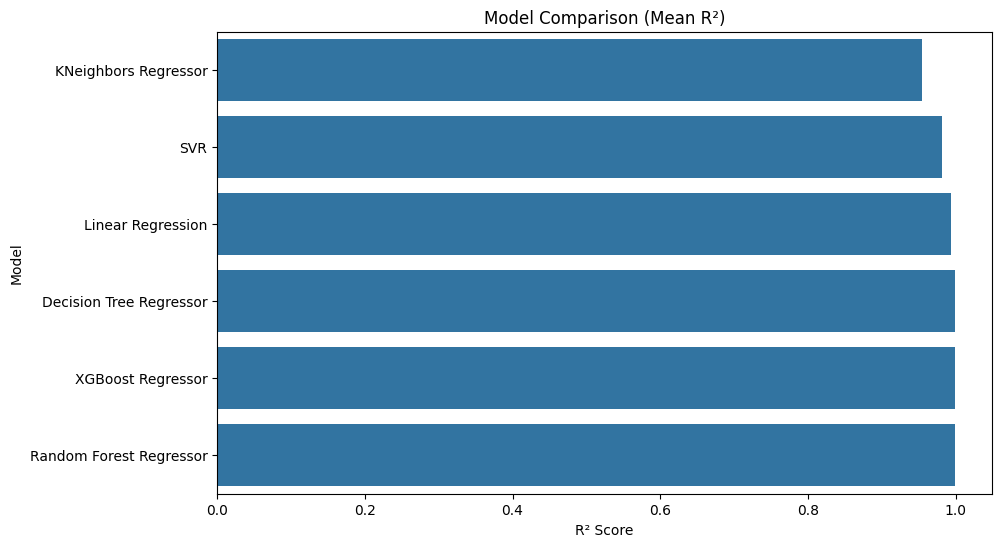

In [60]:
plt.figure(figsize=(10,6))
sns.barplot(x="CV Mean R2", y="Model", data=cv_df.sort_values("CV Mean R2"))
plt.title("Model Comparison (Mean R²)")
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.show()

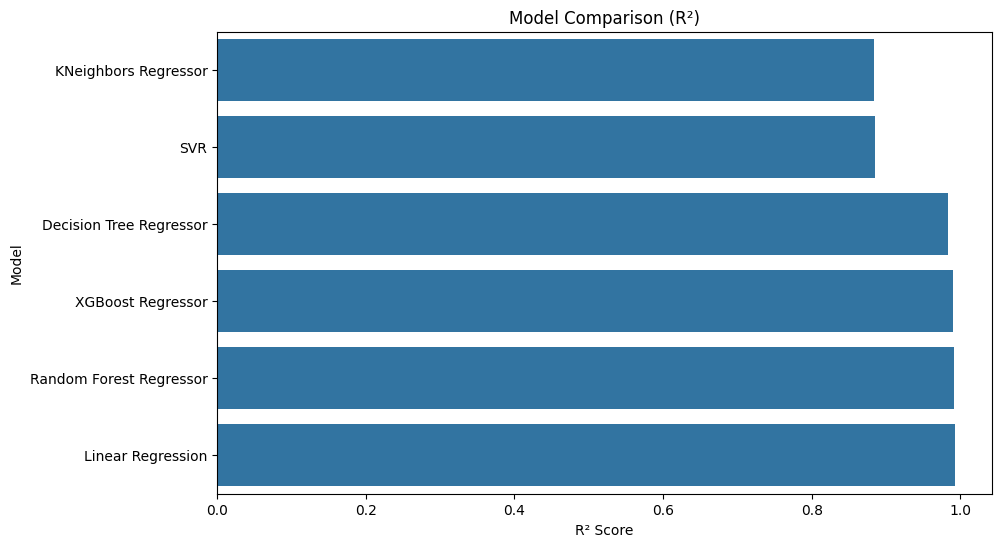

In [61]:
plt.figure(figsize=(10,6))
sns.barplot(x="R2", y="Model", data=cv_df.sort_values("R2"))
plt.title("Model Comparison (R²)")
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.show()

In [62]:
param_grid = {
    'model__fit_intercept': [True, False],
    'model__positive': [True, False],
}

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="r2")
grid_search.fit(X_train, y_train)

,estimator,Pipeline(step...egression())])
,param_grid,"{'model__fit_intercept': [True, False], 'model__positive': [True, False]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [63]:
# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Best Parameters: {'model__fit_intercept': True, 'model__positive': True}
Mean Squared Error: 0.0317
R^2 Score: 0.9940


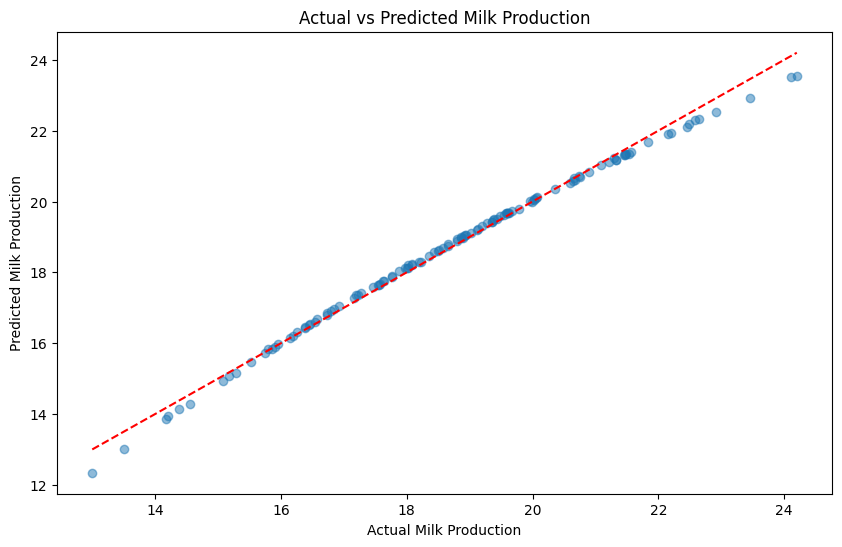

In [64]:
# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Milk Production")
plt.ylabel("Predicted Milk Production")
plt.title("Actual vs Predicted Milk Production")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.show()

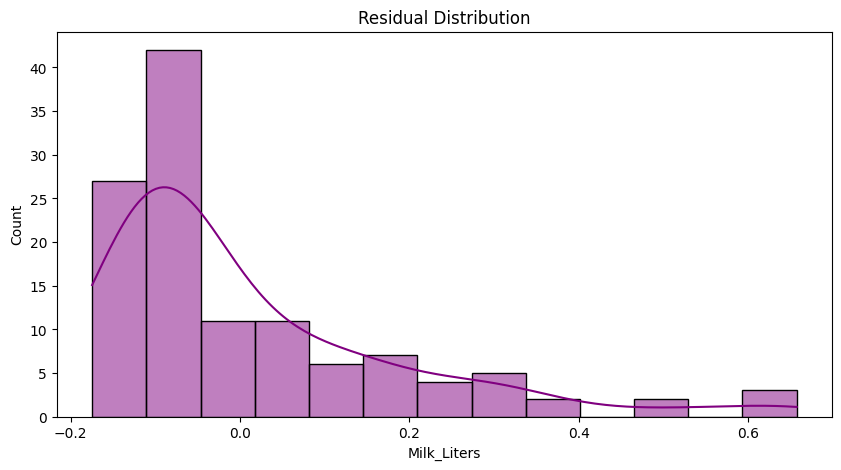

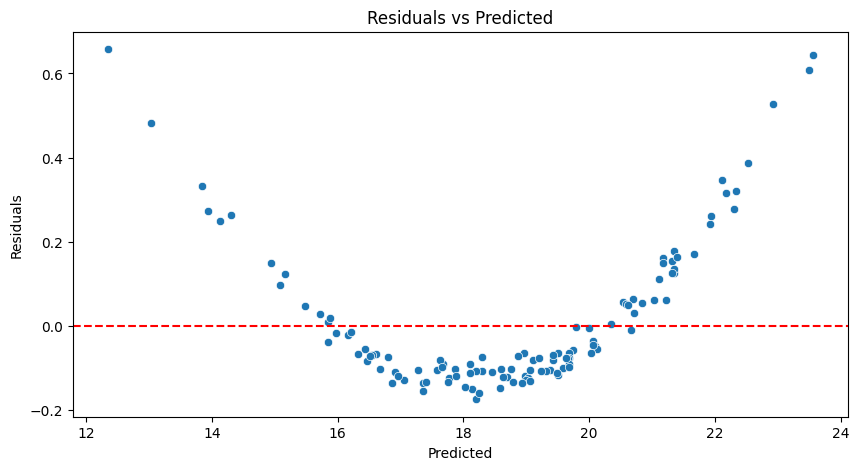

In [65]:
# Residual analysis
residuals = y_test - y_pred
plt.figure(figsize=(10,5))
sns.histplot(residuals, kde=True, color='purple')
plt.title("Residual Distribution")
plt.show()

plt.figure(figsize=(10,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()


In [ ]:
# Accuracy Calculation
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test, y_pred)
accuracy = 100 * (1 - mape)

print(f"MAPE: {mape:.2%}")
print(f"Regression Accuracy (approx): {accuracy:.2f}%")


MAPE: 0.71%
Regression Accuracy (approx): 99.29%


In [ ]:
# Feature Importance using SHAP
for col in num_col:
    print(f"{col}: Mean={df_new[col].mean():.2f}, Median={df_new[col].median():.2f}, Std={df_new[col].std():.2f}")


Feed_kg: Mean=11.94, Median=12.09, Std=1.52
Milking_Time_min: Mean=14.90, Median=15.00, Std=3.19
temp_humidity_ratio: Mean=0.41, Median=0.41, Std=0.06
Milk_Liters_log: Mean=2.97, Median=2.98, Std=0.12


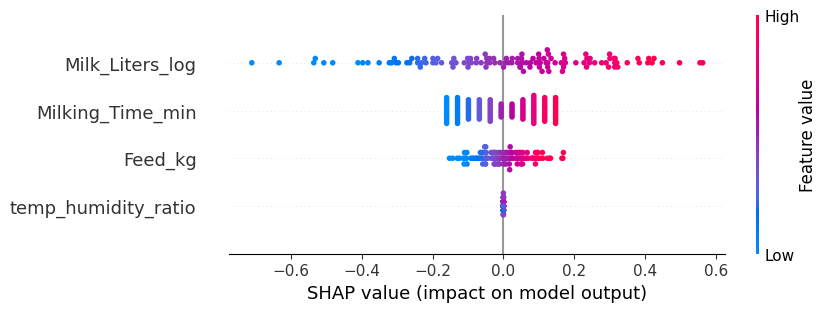

In [ ]:
#SHAP Values: Explain predictions with SHAP (great for originality).
import shap
explainer = shap.Explainer(best_model.named_steps['model'], X_train)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)


<Axes: title={'center': '7-day Rolling Average Milk Production'}, xlabel='Date'>

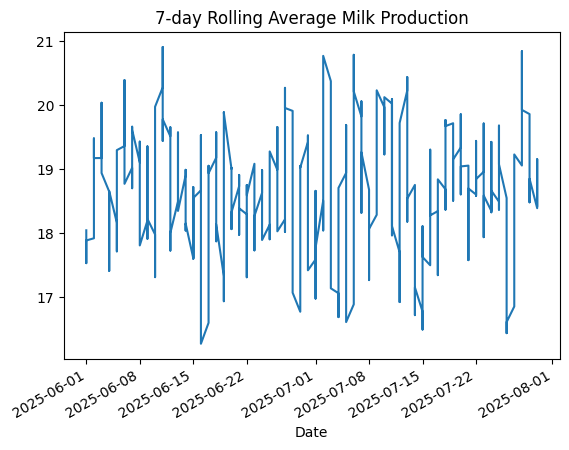

In [ ]:
#Rolling averages or seasonality detection in milk production.
df_new.set_index(pd.to_datetime(df['Date']), inplace=True)
df_new['Milk_Liters'].rolling(7).mean().plot(title="7-day Rolling Average Milk Production")


In [ ]:
# What-if Analysis: Impact of 10% increase in Feed_kg on Milk_Liters
import pandas as pd
import numpy as np

# Original predictions
y_pred_original = best_model.predict(X_test)

# Predictions after 10% increase in Feed_kg
X_test_modified = X_test.copy()
X_test_modified["Feed_kg"] *= 1.1
y_pred_feed10 = best_model.predict(X_test_modified)

# Create a comparison table
comparison_df = pd.DataFrame({
    "Original Milk_Liters": np.round(y_pred_original, 2),
    "Feed_kg +10% Milk_Liters": np.round(y_pred_feed10, 2),
    "Difference": np.round(y_pred_feed10 - y_pred_original, 2),
    "Percentage Increase (%)": np.round((y_pred_feed10 - y_pred_original) / y_pred_original * 100, 2)
})

# Display first 10 rows
print(comparison_df.head(10))


   Original Milk_Liters  Feed_kg +10% Milk_Liters  Difference  \
0                 19.74                     19.78        0.04   
1                 21.23                     21.27        0.04   
2                 16.67                     16.71        0.04   
3                 21.34                     21.38        0.04   
4                 16.16                     16.20        0.03   
5                 23.56                     23.60        0.05   
6                 19.38                     19.42        0.04   
7                 18.30                     18.33        0.03   
8                 15.17                     15.19        0.03   
9                 15.08                     15.12        0.04   

   Percentage Increase (%)  
0                     0.22  
1                     0.20  
2                     0.22  
3                     0.19  
4                     0.21  
5                     0.20  
6                     0.19  
7                     0.18  
8                     0

In [78]:
from sklearn.metrics import r2_score, mean_squared_error

# Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# R² Scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R² Train: {r2_train:.4f}")
print(f"R² Test: {r2_test:.4f}")


R² Train: 0.9944
R² Test: 0.9940


In [79]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validation R² Mean:", cv_scores.mean())


Cross-Validation R² Mean: 0.9942140644369154
